<a href="https://colab.research.google.com/github/davione112/HateSpeechDetection/blob/main/Hate_speech_detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [1]:
# Text CNN 
import pandas as pd 
import numpy as np 
import re
import pickle
import tensorflow as tf
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D,MaxPooling1D,Conv1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate,concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import text, sequence
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/hate_speech_detection

/content/drive/.shortcut-targets-by-id/15esFt6mWnsxUBQ_vxIcTDi0kv6Nx3Brk/hate_speech_detection


In [4]:
train = pd.read_excel("preprocessed_data/train.xlsx")
dev= pd.read_excel("preprocessed_data/dev.xlsx")
test= pd.read_excel("preprocessed_data/test.xlsx")

In [5]:
X_train = train['free_text']
y_train = train['label_id'].values

X_dev = dev['free_text']
y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

In [6]:
X_train = X_train.fillna('NaN')
X_dev = X_dev.fillna('NaN')
X_test = X_test.fillna('NaN')

##CNN

##FastText

In [7]:
EMBEDDING_FILE = 'embedding/cc.vi.300.vec'
MODEL_FILE = 'save_model/Text_CNN_model.h5'

# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

### test1

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     3993300     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 100, 300, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 1, 64)    38464       reshape[0][0]                    
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
85/85 [==============================] - 130s 1s/step - loss: 0.5059 - accuracy: 0.8284 - val_loss: 0.3794 - val_accuracy: 0.8571

Epoch 00001: val_loss improved from inf to 0.37936, saving model to weights.001-0.3794.hdf5
Epoch 2/20
85/85 [==============================] - 66s 778ms/step - loss: 0.3206 - accuracy: 0.8821 - val_loss: 0.3480 - val_accuracy: 0.8713

Epoch 00002: val_loss improved from 0.37936 to 0.34800, saving model to weights.002-0.3480.hdf5
Epoch 3/20
85/85 [==============================] - 66s 780ms/step - loss: 0.2348 - accuracy: 0.9127 - val_loss: 0.3564 - val_accuracy: 0.8707

Epoch 00003: val_loss did not improve from 0.34800
Epoch 4/20
85/85 [==============================] - 69s 811ms/step - loss: 0.1725 - accuracy: 0.9403 - val_loss: 0.3848 - val_accuracy: 0.8626

Epoch 00004: val_loss did not improve from 0.34800
Epoch 5/20
85/85 [==============================] - 66s 774ms/step - loss: 0.1235 - accuracy: 0.9586 - val_loss: 0.4187 - val_accuracy: 

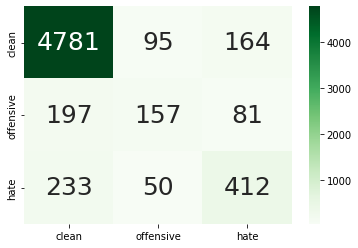

In [8]:
def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 14000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 20
learning_rate = 12e-4
decay_rate = learning_rate / epochs
filter_sizes = [2,3,5,6]
num_filters = 64
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-.2))

from keras.preprocessing import text, sequence
tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
X_train1, y_train1 = make_featues(X_train, y_train, tokenizer)
X_dev1, y_dev1 = make_featues(X_dev, y_dev, tokenizer)
X_test1, y_test1 = make_featues(X_test, y_test, tokenizer, is_one_hot_label=False)

tf.random.set_seed(42)
model = Sequential()
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)
# Make features
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)      
maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_3 = MaxPool2D(pool_size=(sequence_length - filter_sizes[3] + 1, 1), strides=(1,1), padding='valid')(conv_3)


concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(0.4)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)
model.summary()
adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True,
                                       mode='auto'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train1, y_train1, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_dev1, y_dev1),
                    callbacks=my_callbacks)  
model.save(MODEL_FILE)
prediction = model.predict(X_test1, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(y_test1, y_pred)
print(cf1)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greens",fmt='g', cbar=True, annot_kws={"size": 25})
print(classification_report(y_pred, y_test1, digits = 4))


### test 2

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     4175100     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 100, 300, 1)  0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 99, 1, 32)    19232       reshape_2[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
89/89 [==============================] - 36s 401ms/step - loss: 0.7068 - accuracy: 0.8027 - val_loss: 0.5840 - val_accuracy: 0.8189

Epoch 00001: val_loss improved from inf to 0.58401, saving model to weights.001-0.5840.hdf5
Epoch 2/20
89/89 [==============================] - 35s 392ms/step - loss: 0.5412 - accuracy: 0.8271 - val_loss: 0.4867 - val_accuracy: 0.8250

Epoch 00002: val_loss improved from 0.58401 to 0.48672, saving model to weights.002-0.4867.hdf5
Epoch 3/20
89/89 [==============================] - 35s 396ms/step - loss: 0.4706 - accuracy: 0.8381 - val_loss: 0.4415 - val_accuracy: 0.8412

Epoch 00003: val_loss improved from 0.48672 to 0.44150, saving model to weights.003-0.4415.hdf5
Epoch 4/20
89/89 [==============================] - 35s 393ms/step - loss: 0.4298 - accuracy: 0.8471 - val_loss: 0.4164 - val_accuracy: 0.8495

Epoch 00004: val_loss improved from 0.44150 to 0.41643, saving model to weights.004-0.4164.hdf5
Epoch 5/20
89/89 [==========================

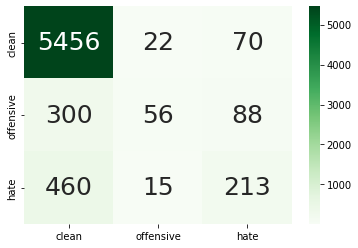

In [ ]:
def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 14000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 20
learning_rate = 2e-4
decay_rate = learning_rate / epochs
filter_sizes = [2,3,5]
num_filters = 32
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-2.))

from keras.preprocessing import text, sequence
tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
X_train1, y_train1 = make_featues(X_train, y_train, tokenizer)
X_dev1, y_dev1 = make_featues(X_dev, y_dev, tokenizer)
X_test1, y_test1 = make_featues(X_test, y_test, tokenizer, is_one_hot_label=False)

tf.random.set_seed(42)
model = Sequential()
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)
# Make features
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)
maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(0.5)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)
model.summary()
adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True,
                                       mode='auto'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train1, y_train1, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_dev1, y_dev1),
                    callbacks=my_callbacks)  
model.save(MODEL_FILE)
prediction = model.predict(X_test1, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(y_test1, y_pred)
print(cf1)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greens",fmt='g', cbar=True, annot_kws={"size": 25})
print(classification_report(y_pred, y_test1, digits = 4))


### test 3

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     4175100     input_4[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 100, 300, 1)  0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 99, 1, 32)    19232       reshape_3[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
89/89 [==============================] - 36s 399ms/step - loss: 0.6068 - accuracy: 0.8161 - val_loss: 0.4667 - val_accuracy: 0.8261

Epoch 00001: val_loss improved from inf to 0.46670, saving model to weights.001-0.4667.hdf5
Epoch 2/20
89/89 [==============================] - 35s 394ms/step - loss: 0.4369 - accuracy: 0.8448 - val_loss: 0.4002 - val_accuracy: 0.8574

Epoch 00002: val_loss improved from 0.46670 to 0.40019, saving model to weights.002-0.4002.hdf5
Epoch 3/20
89/89 [==============================] - 35s 393ms/step - loss: 0.3717 - accuracy: 0.8650 - val_loss: 0.3723 - val_accuracy: 0.8627

Epoch 00003: val_loss improved from 0.40019 to 0.37230, saving model to weights.003-0.3723.hdf5
Epoch 4/20
89/89 [==============================] - 35s 389ms/step - loss: 0.3252 - accuracy: 0.8805 - val_loss: 0.3614 - val_accuracy: 0.8657

Epoch 00004: val_loss improved from 0.37230 to 0.36142, saving model to weights.004-0.3614.hdf5
Epoch 5/20
89/89 [==========================

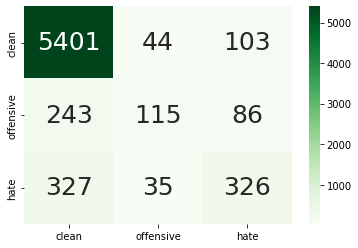

In [ ]:
def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 14000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 20
learning_rate = 5e-4
decay_rate = learning_rate / epochs
filter_sizes = [2,3,5]
num_filters = 32
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-2.))

from keras.preprocessing import text, sequence
tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
X_train1, y_train1 = make_featues(X_train, y_train, tokenizer)
X_dev1, y_dev1 = make_featues(X_dev, y_dev, tokenizer)
X_test1, y_test1 = make_featues(X_test, y_test, tokenizer, is_one_hot_label=False)

tf.random.set_seed(42)
model = Sequential()
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)
# Make features
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid',
                kernel_initializer='normal', activation='relu')(reshape)
maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(0.5)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)
model.summary()
adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True,
                                       mode='auto'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train1, y_train1, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_dev1, y_dev1),
                    callbacks=my_callbacks)  
model.save(MODEL_FILE)
prediction = model.predict(X_test1, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(y_test1, y_pred)
print(cf1)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greens",fmt='g', cbar=True, annot_kws={"size": 25})
print(classification_report(y_pred, y_test1, digits = 4))


In [ ]:
# # channel 1
# 	conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding)
# 	drop1 = Dropout(0.5)(conv1)
# 	pool1 = MaxPooling1D(pool_size=2)(drop1)
# 	flat1 = Flatten()(pool1)
# 	# channel 2
# 	conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding)
# 	drop2 = Dropout(0.5)(conv2)
# 	pool2 = MaxPooling1D(pool_size=2)(drop2)
# 	flat2 = Flatten()(pool2)
# 	# channel 3
# 	conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding)
# 	drop3 = Dropout(0.5)(conv3)
# 	pool3 = MaxPooling1D(pool_size=2)(drop3)
# 	flat3 = Flatten()(pool3)
# 	# merge
# 	merged = concatenate([flat1, flat2, flat3])
# 	# interpretation
# 	dense1 = Dense(10, activation='relu')(merged)
# 	outputs = Dense(3, activation='softmax')(dense1)
# 	model = Model(inputs=[inputs], outputs=outputs)

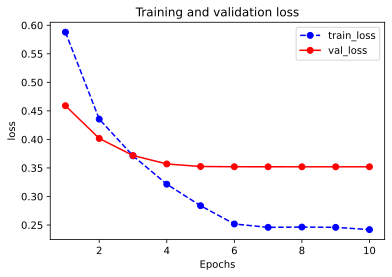

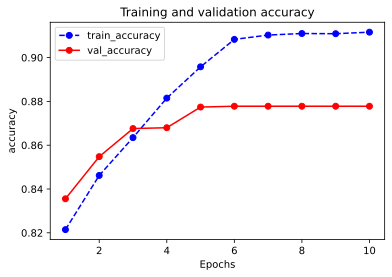

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')

## PhoW2V

In [ ]:
EMBEDDING_FILE = 'embedding/word2vec_vi_words_300dims.txt'
MODEL_FILE = 'save_model/Text_CNN_model_PhoW2V.h5'
# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

## 3 layers

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 120, 300)     3993300     input_6[0][0]                    
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 120, 300, 1)  0           embedding_5[0][0]                
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 119, 1, 32)   19232       reshape_5[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
85/85 [==============================] - 42s 488ms/step - loss: 0.5220 - accuracy: 0.8278 - val_loss: 0.3658 - val_accuracy: 0.8613

Epoch 00001: val_loss improved from inf to 0.36577, saving model to weights.001-0.3658.hdf5
Epoch 2/10
85/85 [==============================] - 41s 486ms/step - loss: 0.3208 - accuracy: 0.8793 - val_loss: 0.3355 - val_accuracy: 0.8759

Epoch 00002: val_loss improved from 0.36577 to 0.33549, saving model to weights.002-0.3355.hdf5
Epoch 3/10
85/85 [==============================] - 40s 473ms/step - loss: 0.2414 - accuracy: 0.9112 - val_loss: 0.3480 - val_accuracy: 0.8707

Epoch 00003: val_loss did not improve from 0.33549
Epoch 4/10
85/85 [==============================] - 41s 479ms/step - loss: 0.1784 - accuracy: 0.9354 - val_loss: 0.3667 - val_accuracy: 0.8687

Epoch 00004: val_loss did not improve from 0.33549
Epoch 5/10
85/85 [==============================] - 41s 481ms/step - loss: 0.1332 - accuracy: 0.9544 - val_loss: 0.4009 - val_accuracy

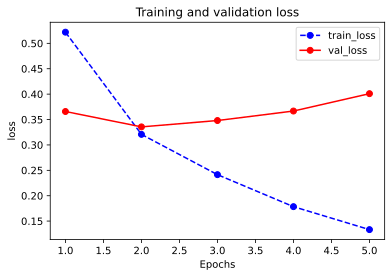

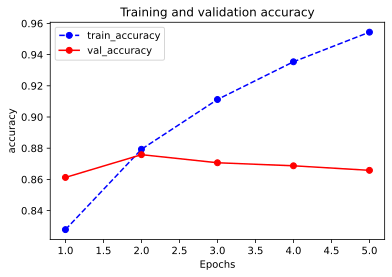

In [ ]:
vocabulary_size = 14000
sequence_length = 120

embedding_dim = 300
batch_size = 256
epochs = 10
drop = 0.5
learning_rate = 12e-4
decay_rate = learning_rate / epochs
filter_sizes = [2,3,5]
num_filters = 32

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)

    return X, y

def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-.1))

X_train = train['free_text']
y_train = train['label_id'].values

X_dev = dev['free_text']
y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

X_train = X_train.fillna('NaN')
X_dev = X_dev.fillna('NaN')
X_test = X_test.fillna('NaN')

from keras.preprocessing import text, sequence
tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
X_train, y_train = make_featues(X_train, y_train, tokenizer)
X_dev, y_dev = make_featues(X_dev, y_dev, tokenizer)
X_test, y_test = make_featues(X_test, y_test, tokenizer, is_one_hot_label=False)

tf.random.set_seed(42)
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)
# Make features
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)
model.summary()
adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_dev, y_dev),callbacks=my_callbacks)  
model.save(MODEL_FILE)
prediction = model.predict(X_test, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(y_test, y_pred)
print(cf1)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greens",fmt='g', cbar=True, annot_kws={"size": 25})
print(classification_report(y_pred, y_test, digits = 4))
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')

## 4 layers

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     3993300     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 100, 300, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 1, 64)    38464       reshape[0][0]                    
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
85/85 [==============================] - 123s 965ms/step - loss: 0.4843 - accuracy: 0.8313 - val_loss: 0.3536 - val_accuracy: 0.8635

Epoch 00001: val_loss improved from inf to 0.35359, saving model to weights.001-0.3536.hdf5
Epoch 2/10
85/85 [==============================] - 69s 816ms/step - loss: 0.2894 - accuracy: 0.8911 - val_loss: 0.3343 - val_accuracy: 0.8736

Epoch 00002: val_loss improved from 0.35359 to 0.33426, saving model to weights.002-0.3343.hdf5
Epoch 3/10
85/85 [==============================] - 69s 814ms/step - loss: 0.2042 - accuracy: 0.9246 - val_loss: 0.3621 - val_accuracy: 0.8716

Epoch 00003: val_loss did not improve from 0.33426
Epoch 4/10
85/85 [==============================] - 69s 813ms/step - loss: 0.1402 - accuracy: 0.9520 - val_loss: 0.3979 - val_accuracy: 0.8580

Epoch 00004: val_loss did not improve from 0.33426
Epoch 5/10
85/85 [==============================] - 69s 808ms/step - loss: 0.0959 - accuracy: 0.9682 - val_loss: 0.4448 - val_accurac

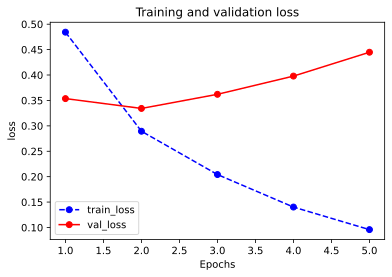

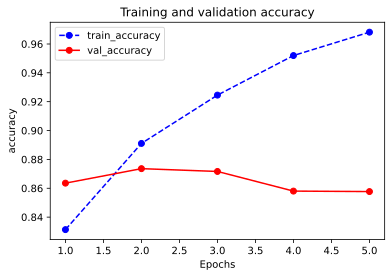

In [ ]:
vocabulary_size = 14000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 10
drop = 0.4
learning_rate = 12e-4
decay_rate = learning_rate / epochs
filter_sizes = [2,3,5,6]
num_filters = 64

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)

    return X, y

def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-.1))

X_train = train['free_text']
y_train = train['label_id'].values

X_dev = dev['free_text']
y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

X_train = X_train.fillna('NaN')
X_dev = X_dev.fillna('NaN')
X_test = X_test.fillna('NaN')

from keras.preprocessing import text, sequence
tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
X_train, y_train = make_featues(X_train, y_train, tokenizer)
X_dev, y_dev = make_featues(X_dev, y_dev, tokenizer)
X_test, y_test = make_featues(X_test, y_test, tokenizer, is_one_hot_label=False)

tf.random.set_seed(42)
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)
# Make features
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal',
                activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal',
                activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal',
                activation='elu')(reshape)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embedding_dim), padding='valid', kernel_initializer='normal',
                activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_3 = MaxPool2D(pool_size=(sequence_length - filter_sizes[3] + 1, 1), strides=(1,1), padding='valid')(conv_3)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)
model.summary()
adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_dev, y_dev),callbacks=my_callbacks)  
model.save(MODEL_FILE)
prediction = model.predict(X_test, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(y_test, y_pred)
print(cf1)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greens",fmt='g', cbar=True, annot_kws={"size": 25})
print(classification_report(y_pred, y_test, digits = 4))
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')